# Определение токсичных комментариев c BERT

**Описание проекта**

Интернет-магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Задача:**

Обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Цель:**

Построить модель со значением метрики качества *F1* не меньше 0.75.

**Ход проекта:**

1. Подготовка данных
2. Обучение моделей
3. Тестирование лучшей модели
4. Выводы

## Подготовка данных

In [ ]:
!pip install catboost phik -q
!pip install imbalanced-learn -q

In [ ]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import re
import nltk
import string
import transformers
import random

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

from scipy.stats import ttest_ind

from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Subset
from torch.utils.data import Dataset

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertConfig, BertModel
from transformers.optimization import get_linear_schedule_with_warmup

from tqdm.auto import tqdm
from tqdm import notebook
from tqdm import tqdm

from catboost import CatBoostClassifier

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from wordcloud import WordCloud, STOPWORDS

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')  # Основной теггер для английского
nltk.download('wordnet')  # Для лемматизации
nltk.download('omw-1.4')  # Open Multilingual Wordnet
nltk.download('punkt_tab')  # Токенизатор

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
RANDOM_STATE = 42 # Фиксируем random_state для воспроизводимости

In [ ]:
# настройка среды для работы
# зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.3f}'.format)

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# Сброс ограничений на число столбцов
pd.set_option('display.max_rows', None)

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [ ]:
def get_info(data):

    if data is None:
        print("Датасет пуст (None).")
        return

    try:
        print("Первые 5 строк:")
        display(data.head())

        print("\nОбщая информация:")
        data.info()

        print("\nОсновные статистики:")
        display(data.describe())

        print("\nКоличество явных дубликатов:", data.duplicated().sum())

        print("\nКоличество пропусков:")
        print(data.isna().sum())

    except Exception as e:
        print(f"Ошибка при выводе информации: {e}")

In [ ]:
get_info(df)

Первые 5 строк:


,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB

Основные статистики:


,Unnamed: 0,toxic
count,"159,292.000","159,292.000"
mean,"79,725.697",0.102
std,"46,028.837",0.302
min,0.000,0.000
25%,"39,872.750",0.000
50%,"79,721.500",0.000
75%,"119,573.250",0.000
max,"159,450.000",1.000



Количество явных дубликатов: 0

Количество пропусков:
Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [ ]:
#проверим дубликаты по индексу
df.index.duplicated().sum()

0

In [ ]:
#проверим дубликаты по столбцам 'text'и 'toxic'
len(df[df.duplicated(subset=['text', 'toxic'], keep=False)])

0

In [ ]:
#проверим дубликаты в столбце 'text'
len(df[df.duplicated(subset=['text'], keep=False)])

0

In [ ]:
df['toxic'].value_counts(normalize=True)

,proportion
toxic,
0,0.898
1,0.102


**Вывод:**

- В датасете 159 292 объектов.
- Пропусков нет, явных дубликатов нет
- Тексты комментариев на английском.
- Тип данных для text -  object преобразование в unicode не требуется
- Тип данных для toxic - int64 - преобразуем в unicode
- выраженный дисбаланс классов, что следует учесть при обучении модели.

### Предобработка текста

**Облако слов**

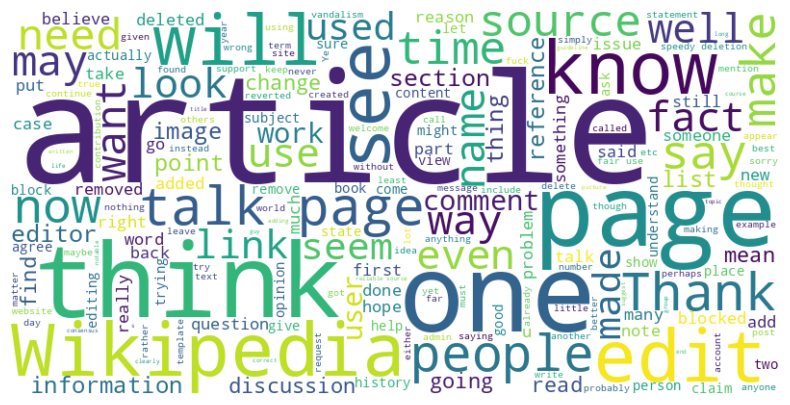

In [ ]:
text = " ".join(df['text'])  # Объединяем все тексты в одну строку

# Создаем облако слов
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=None  # Используем шрифт по умолчанию
).generate(text)

# Визуализируем
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Выполним следующие шаги в рамках предобработки текста:
1. Приведение к нижнему регистру: Некоторые лемматизаторы (например, WordNetLemmatizer из NLTK) чувствительны к регистру. Если слово начинается с заглавной буквы, лемматизатор может не распознать его корректно. Это должно быть первым шагом, чтобы все символы были в одном регистре перед дальнейшей обработкой.

2. Удаление символов: Лемматизаторы (например, WordNetLemmatizer) работают только с текстовыми словами, поэтому неалфавитные символы могут вызвать ошибки или некорректные результаты. После приведения к нижнему регистру удаляем ненужные символы (знаки препинания, цифры и т.д.), оставляя только буквы, пробелы, апострофы и смайлики.

3. После этого удалим слова длиннее max_word_length.

4. Удаление лишних пробелов: После удаления символов могут остаться лишние пробелы, которые нужно убрать.

5. Лемматизация: Лемматизация должна выполняться после очистки текста, чтобы работать только с корректными словами.

6. Удаление дубликатов слов: Удаление дубликатов слов лучше выполнять после лемматизации, так как лемматизация может привести разные формы слов к одной лемме, что увеличит количество дубликатов.

In [ ]:
# Инициализация лемматизатора и списка стоп-слов
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def get_wordnet_pos(word):
    """Получает часть речи для лемматизации."""
    try:
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV
        }
        return tag_dict.get(tag, wordnet.NOUN)
    except IndexError:
        return wordnet.NOUN

In [ ]:
def clear_text(text, max_word_length=20):
    try:
        # Приведение текста к нижнему регистру
        text = text.lower()

        # Удаляем все символы, кроме букв, пробелов, апострофов
        text = re.sub(r"[^a-zA-Z\s]", ' ', text)

        # Удаляем слова длиннее max_word_length
        words = text.split()
        processed_words = [word for word in words if len(word) <= max_word_length]
        text = ' '.join(processed_words)

        # Удаляем лишние пробелы
        text = re.sub(r'\s+', ' ', text).strip()

        return text
    except Exception as e:
        print(f"Ошибка предварительной обработки: {e}")
        return ""

In [ ]:
def lemmatize_text(text):
    """Лемматизация текста с удалением стоп-слов."""
    try:
        # Разделение текста на слова
        words = text.split()

        # Удаление стоп-слов
        words = [word for word in words if word.lower() not in stop_words]

        # Лемматизация каждого слова
        words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

        # Объединение слов обратно в текст
        return ' '.join(words)
    except Exception as e:
        print(f"Ошибка лемматизации: {e}")
        return ""

In [ ]:
def remove_duplicate_words(text):
    words = text.split()
    unique_words = list(dict.fromkeys(words))  # Удаление дубликатов с сохранением порядка
    return ' '.join(unique_words)

In [ ]:
df['lemm_text'] = [clear_text(text) for text in tqdm(df['text'], desc="Очистка текста")]

Очистка текста: 100%|██████████| 159292/159292 [00:07<00:00, 21469.58it/s]


In [ ]:
df['lemm_text'] = [lemmatize_text(text) for text in tqdm(df['lemm_text'], desc="Лемматизация текста")]

Лемматизация текста: 100%|██████████| 159292/159292 [05:46<00:00, 459.16it/s]


In [ ]:
df['lemm_text'] = [remove_duplicate_words(text) for text in tqdm(df['lemm_text'], desc="Удаление дубликатов слов в тексте")]

Удаление дубликатов слов в тексте: 100%|██████████| 159292/159292 [00:01<00:00, 132762.37it/s]


In [ ]:
# Проверяем, есть ли пустые строки в столбце 'lemm_text'
df['lemm_text'].str.strip().eq('').sum()

63

In [ ]:
# Проверяем на строки NaN
df['lemm_text'].isna().sum()

0

In [ ]:
# Удаляем строки, где 'lemm_text' состоит только из пробелов или пуст
df = df[~df['lemm_text'].str.strip().eq('')]

In [ ]:
# Проверяем, есть ли пустые строки в столбце 'lemm_text'
df['lemm_text'].str.strip().eq('').sum()

0

In [ ]:
# Проверяем дубликаты по столбцам 'lemm_text', 'toxic' после лемматизации
len(df[df.duplicated(subset=['lemm_text', 'toxic'], keep=False)])

3219

In [ ]:
# Удаляем дубликаты, оставляя первый экземпляр
df_cleaned = df.drop_duplicates(subset=['lemm_text', 'toxic'], keep='first')

In [ ]:
len(df_cleaned[df_cleaned.duplicated(subset=['lemm_text', 'toxic'], keep=False)])

0

In [ ]:
# Проверяем дубликаты в столбце 'lemm_text'
len(df_cleaned[df_cleaned.duplicated(subset=['lemm_text'], keep=False)])

90

In [ ]:
# выведем строки, где есть дубликаты в столбце 'lemm_text'
d = df_cleaned[df_cleaned.duplicated(subset=['lemm_text'], keep=False)]
d[['lemm_text', 'toxic']].sort_values(by='lemm_text').head(5)

,lemm_text,toxic
122582,ahhhh always feel good last word get although sign edits see sinbot person start discussion format table lol yes everybody less agree upon non descript colour fair enough well heading jack merridew go post somewhere else miley cyrus fan scheme idiot never even heard creature happen page quite frank think would like music hear year old nitwit know look apparently spend half every day edit wikipedia entry font please life,1
56002,ahhhh always feel good last word get although sign edits see sinbot person start discussion format table lol yes everybody less agree upon non descript colour fair enough well heading jack merridew go post somewhere else miley cyrus fan scheme idiot never even heard creature happen page quite frank think would like music hear year old nitwit know look apparently spend half every day edit wikipedia entry font please life,0
81849,ankit fadia white hat hacker serial liar kind security professional trade rat attendee def con conference large world charlatan year call author several book subject ethical hack factual like barack obama president russia plagiarize first chapter another party know article merit page wikipedia please look http securityerrata org erratum consider delete,1
66623,ankit fadia white hat hacker serial liar kind security professional trade rat attendee def con conference large world charlatan year call author several book subject ethical hack factual like barack obama president russia plagiarize first chapter another party know article merit page wikipedia please look http securityerrata org erratum consider delete,0
151323,assume good faith someone add anti semitic lie article obvious ignorance subject excuse,0


есть дубликаты в столбце 'lemm_text', но не совпадает таргет. удалим все такие строки, так как они только запутают модель.

In [ ]:
# Удаляем все дубликаты в lemm_text
df_cleaned = df_cleaned.drop_duplicates(subset=['lemm_text'], keep=False)

In [ ]:
len(df_cleaned[df_cleaned.duplicated(subset=['lemm_text'], keep=False)])

0

In [ ]:
# для экономии памяти и потенциального повышения производительности
df['toxic'] = df['toxic'].astype('uint8')

### Анализ длины текстов

In [ ]:
# Добавляем длины текстов
df_cleaned = df_cleaned.assign(
    text_length=df_cleaned['text'].apply(len),
    lemm_text_length=df_cleaned['lemm_text'].apply(len)
)

In [ ]:
df_cleaned.head(2)

,Unnamed: 0,text,toxic,lemm_text,text_length,lemm_text_length
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire,264,152
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww match background colour seemingly stuck thanks talk january utc,112,67


In [ ]:
# Находим максимальную длину для каждого столбца
max_lengths = {
    'max_text_length': df_cleaned['text_length'].max(),
    'max_lemm_text_length': df_cleaned['lemm_text_length'].max()
}

# Вывод результата
print(max_lengths)

{'max_text_length': 5000, 'max_lemm_text_length': 2691}


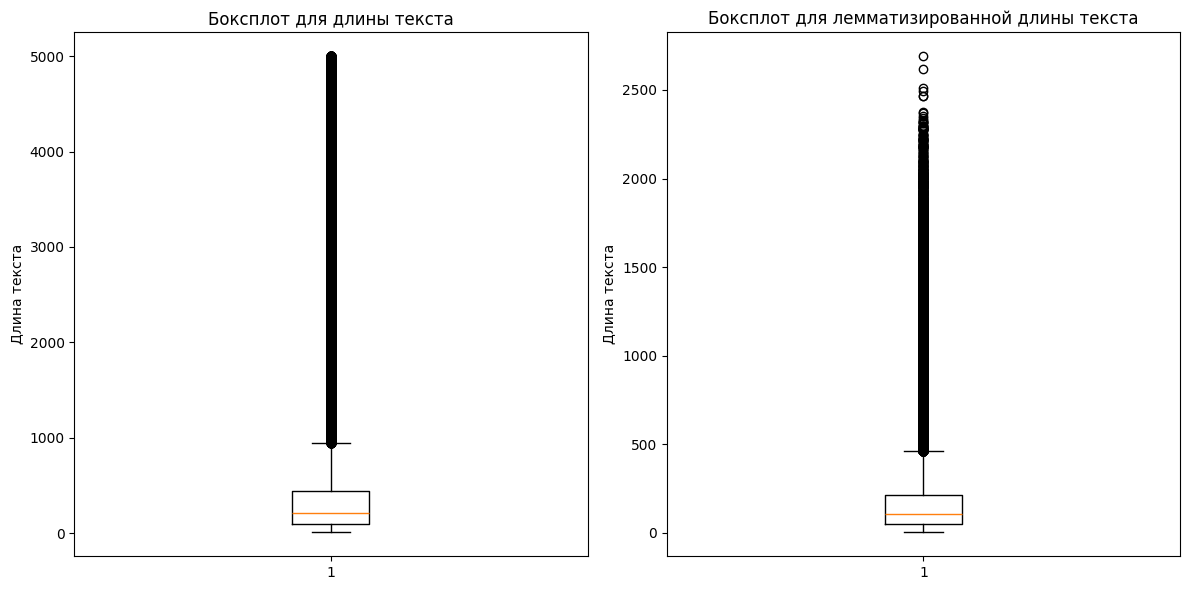

In [ ]:
# Создаем фигуру с двумя subplots (1 строка, 2 столбца)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Боксплот для text_length
axes[0].boxplot(df_cleaned['text_length'])
axes[0].set_title('Боксплот для длины текста')
axes[0].set_ylabel('Длина текста')

# Боксплот для lemm_text_length
axes[1].boxplot(df_cleaned['lemm_text_length'])
axes[1].set_title('Боксплот для лемматизированной длины текста')
axes[1].set_ylabel('Длина текста')

# Отображаем графики
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

Боксплот для 'text': выбросы все, что больше 800-900. Медиана не стремится к ним.

Боксплот для 'lemm_teext': выбросы все, что больше примерно 400. Медиана не стремится к ним.

In [ ]:
# Описательная статистика для каждого столбца
lemm_stats = df_cleaned['lemm_text_length'].describe().rename('lemm_text_length')
text_stats = df_cleaned['text_length'].describe().rename('text_length')

# Объединяем статистику в одну таблицу
combined_stats = pd.concat([lemm_stats, text_stats], axis=1)

# Выводим результат
print(combined_stats)

       lemm_text_length  text_length
count       157,019.000  157,019.000
mean            182.434      394.776
std             232.723      589.006
min               2.000        6.000
25%              52.000       97.000
50%             108.000      207.000
75%             216.000      437.000
max           2,691.000    5,000.000


   • Для lemm_text_length:

     • 25% текстов имеют длину до 52 символов.

     • Медиана (50%) составляет 108 символов.

     • 75% текстов имеют длину до 216 символов.

   • Для text_length:

     • 25% текстов имеют длину до 97 символов.

     • Медиана (50%) составляет 207 символов.

     • 75% текстов имеют длину до 437 символов.

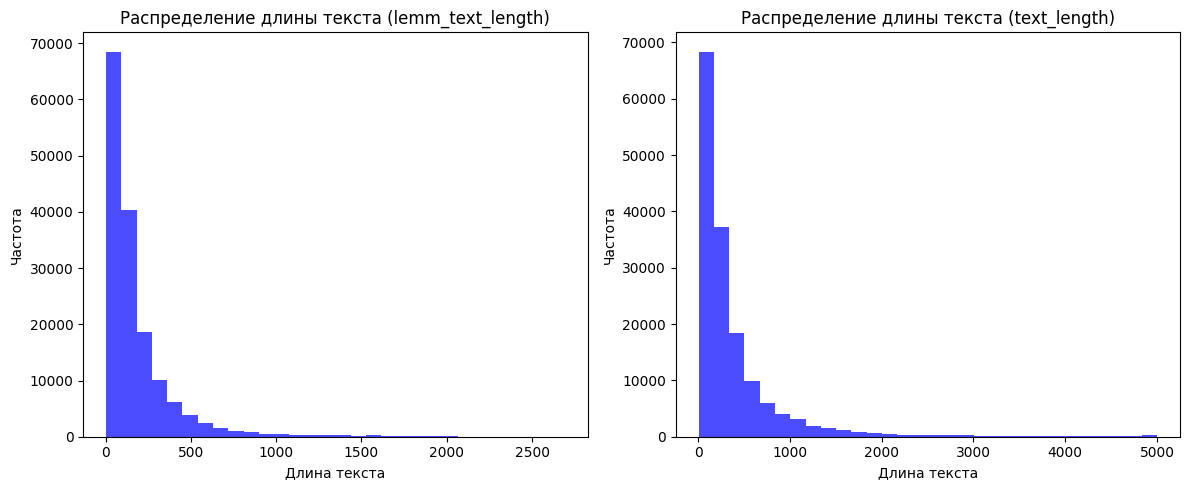

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма для lemm_text_length
axes[0].hist(df_cleaned['lemm_text_length'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('Распределение длины текста (lemm_text_length)')
axes[0].set_xlabel('Длина текста')
axes[0].set_ylabel('Частота')

# Гистограмма для text_length
axes[1].hist(df_cleaned['text_length'], bins=30, color='blue', alpha=0.7)
axes[1].set_title('Распределение длины текста (text_length)')
axes[1].set_xlabel('Длина текста')
axes[1].set_ylabel('Частота')

# Отображаем графики
plt.tight_layout()
plt.show()

Проанализируем, связано ли распределение длины текста с тагретом

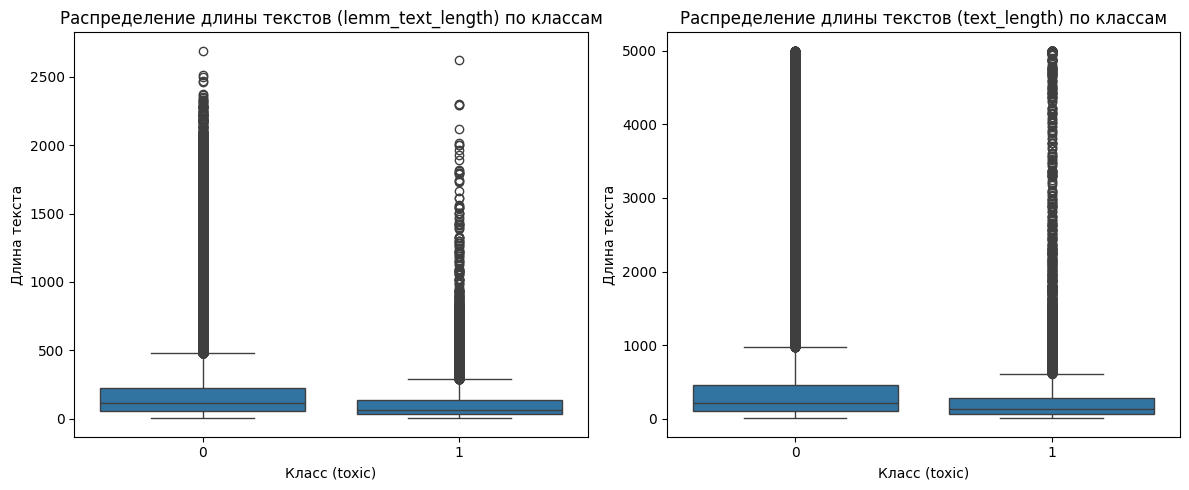

In [ ]:
# Создаем фигуру с двумя подграфиками, расположенными в одной строке и двух столбцах
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Боксплот для lemm_text_length
sns.boxplot(x='toxic', y='lemm_text_length', data=df_cleaned, ax=axes[0])
axes[0].set_title('Распределение длины текстов (lemm_text_length) по классам')
axes[0].set_xlabel('Класс (toxic)')
axes[0].set_ylabel('Длина текста')

# Боксплот для text_length
sns.boxplot(x='toxic', y='text_length', data=df_cleaned, ax=axes[1])
axes[1].set_title('Распределение длины текстов (text_length) по классам')
axes[1].set_xlabel('Класс (toxic)')
axes[1].set_ylabel('Длина текста')

# Отображаем графики
plt.tight_layout()
plt.show()

Боксплоты для текста и для лемм. текста показывают, что для токсичного класса характерны тексты меньшей длины, однако разница не большая.

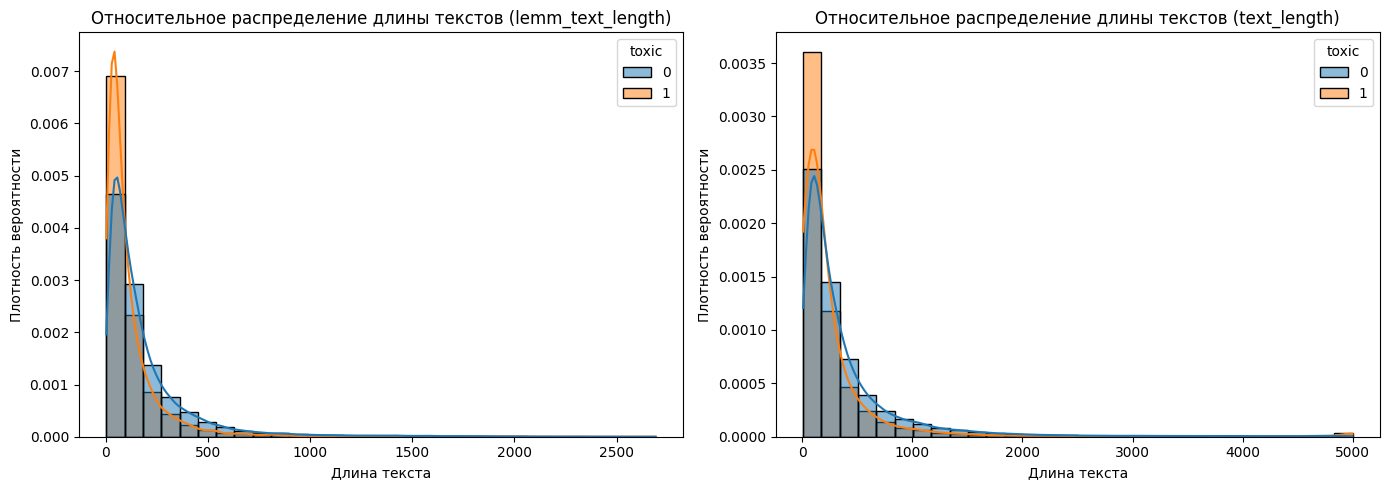

In [ ]:
# Создаем фигуру с двумя подграфиками, расположенными в одной строке и двух столбцах
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма для lemm_text_length
sns.histplot(data=df_cleaned, x='lemm_text_length', hue='toxic', kde=True, bins=30, stat='density', common_norm=False, ax=axes[0])
axes[0].set_title('Относительное распределение длины текстов (lemm_text_length)')
axes[0].set_xlabel('Длина текста')
axes[0].set_ylabel('Плотность вероятности')

# Гистограмма для text_length
sns.histplot(data=df_cleaned, x='text_length', hue='toxic', kde=True, bins=30, stat='density', common_norm=False, ax=axes[1])
axes[1].set_title('Относительное распределение длины текстов (text_length)')
axes[1].set_xlabel('Длина текста')
axes[1].set_ylabel('Плотность вероятности')

# Отображаем графики
plt.tight_layout()
plt.show()

У класса toxic=1 и 0 есть пик в области меньших значений длины исходного и лемм. текстов, это может означать, что короткие тексты чаще являются токсичными.


In [ ]:
# Разделим данные на две группы по классам
group_0 = df_cleaned[df_cleaned['toxic'] == 0]['text_length']
group_1 = df_cleaned[df_cleaned['toxic'] == 1]['text_length']

# Проведем t-тест для сравнения средних
t_stat, p_value = ttest_ind(group_0, group_1)
print(f"T-статистика: {t_stat}, p-значение: {p_value}")

# Интерпретация результата
if p_value < 0.05:
    print("Есть статистически значимая разница в длине исходного текста между классами.")
else:
    print("Нет статистически значимой разницы в длине исходного текста между классами.")

T-статистика: 22.011364296433744, p-значение: 3.259728740496156e-107
Есть статистически значимая разница в длине исходного текста между классами.


In [ ]:
# Разделим данные на две группы по классам
group_0 = df_cleaned[df_cleaned['toxic'] == 0]['lemm_text_length']
group_1 = df_cleaned[df_cleaned['toxic'] == 1]['lemm_text_length']

# Проведем t-тест для сравнения средних
t_stat, p_value = ttest_ind(group_0, group_1)
print(f"T-статистика: {t_stat}, p-значение: {p_value}")

# Интерпретация результата
if p_value < 0.05:
    print("Есть статистически значимая разница в длине лемм. текста между классами.")
else:
    print("Нет статистически значимой разницы в длине лемм. текста между классами.")

T-статистика: 37.49259135619103, p-значение: 2.7874085225833944e-306
Есть статистически значимая разница в длине лемм. текста между классами.


In [ ]:
# Вычисляем корреляцию
correlation = df_cleaned['lemm_text_length'].corr(df_cleaned['toxic'])
print(f"Корреляция между длиной лемм. текста и целевой переменной: {correlation}")

# Интерпретация результата
if abs(correlation) > 0.3:
    print("Есть умеренная или сильная корреляция.")
else:
    print("Корреляция слабая или отсутствует.")

Корреляция между длиной лемм. текста и целевой переменной: -0.09419693257658436
Корреляция слабая или отсутствует.


In [ ]:
# Вычисляем корреляцию
correlation = df_cleaned['text_length'].corr(df_cleaned['toxic'])
print(f"Корреляция между длиной исходного текста и целевой переменной: {correlation}")

# Интерпретация результата
if abs(correlation) > 0.3:
    print("Есть умеренная или сильная корреляция.")
else:
    print("Корреляция слабая или отсутствует.")

Корреляция между длиной исходного текста и целевой переменной: -0.05546316057259213
Корреляция слабая или отсутствует.


Средняя длина текста (lemm_text_length) по классам:
toxic
0   189.776
1   116.981
Name: lemm_text_length, dtype: float64
Средняя длина текста (text_length) по классам:
toxic
0   405.718
1   297.238
Name: text_length, dtype: float64


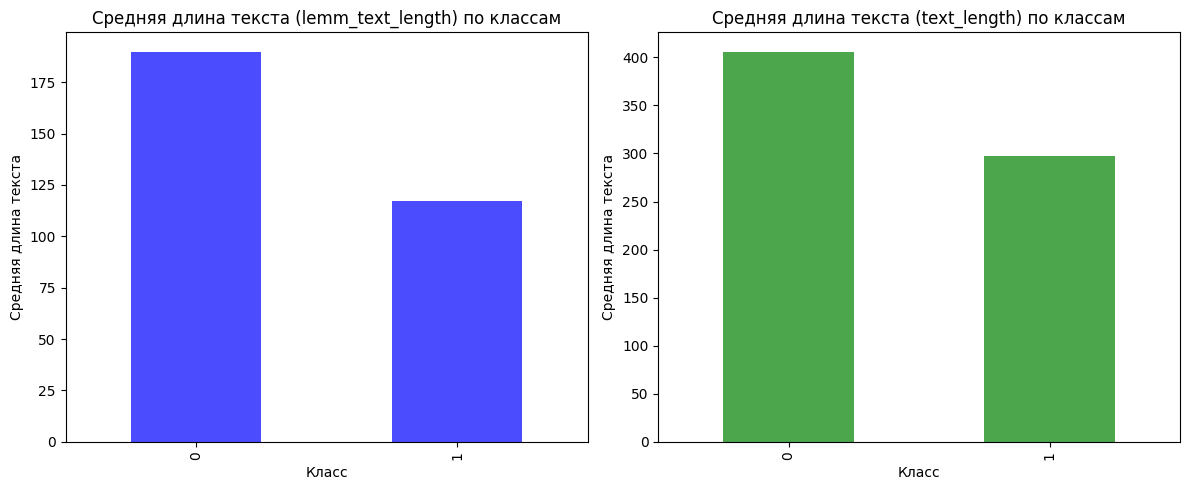

In [ ]:
import matplotlib.pyplot as plt

# Группируем данные по целевой переменной и вычисляем среднюю длину текста для lemm_text_length
grouped_lemm = df_cleaned.groupby('toxic')['lemm_text_length'].mean()
print("Средняя длина текста (lemm_text_length) по классам:")
print(grouped_lemm)

# Группируем данные по целевой переменной и вычисляем среднюю длину текста для text_length
grouped_text = df_cleaned.groupby('toxic')['text_length'].mean()
print("Средняя длина текста (text_length) по классам:")
print(grouped_text)

# Создаем фигуру с двумя подграфиками, расположенными в одной строке и двух столбцах
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# График для lemm_text_length
grouped_lemm.plot(kind='bar', ax=axes[0], color='blue', alpha=0.7)
axes[0].set_title('Средняя длина текста (lemm_text_length) по классам')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Средняя длина текста')

# График для text_length
grouped_text.plot(kind='bar', ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('Средняя длина текста (text_length) по классам')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Средняя длина текста')  # Здесь нужно передать строку

# Показать графики
plt.tight_layout()  # Для улучшения размещения графиков
plt.show()


Вывод:

Анализ графиков и результаты статистического теста показывают, что есть статистическая разница в длине исходного и лемм. текста между классами.

Однако корреляционный анализ показывает, что не установлена связь между длиной текста и таргетом.

Визуальный анализ графиков показывает что рзница есть, но не значительная.

### Распределение меток в целевом признаке

In [ ]:
# Подсчет соотношения меток
df.toxic.value_counts(normalize=True)

,proportion
toxic,
0,0.898
1,0.102


Видим существенный дисбаланс таргета: 89,8% класс 0, 10,2% класс 1. Надо будет учесть при обучении моделей.

**Вывод**:

1. Большинство текстов - короткие.
2. Связь между метками классов и длиной текстов не установлена.
3. Существенный дисбаланс в таргете.

## Обучение моделей

### Logistic Regression

In [ ]:
X = df.lemm_text
y = df.toxic

In [ ]:
# Разбиваем датасет на учебную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify = y, # стратификация для сохранненя пропорцй меток таргета в выборках
    random_state=RANDOM_STATE
)

In [ ]:
#смотрю размеры выборок:
for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(127383,)
(127383,)
(31846,)
(31846,)


In [ ]:
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train type: <class 'pandas.core.series.Series'>
y_train type: <class 'pandas.core.series.Series'>


In [ ]:
print("Распределение меток в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print("\nРаспределение меток в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Распределение меток в обучающей выборке:
toxic
0   0.898
1   0.102
Name: proportion, dtype: float64

Распределение меток в тестовой выборке:
toxic
0   0.898
1   0.102
Name: proportion, dtype: float64


In [ ]:
X_train.head(2)

,lemm_text
132994,already ban ya gonna asshole
61439,edit thon tomorrow saturday oakland hi hope join u afternoon tech liminal work article relate woman democracy anything else interest sponsor california league voter first hearing event apology last minute notice announce san francisco email list banner watchlist neglect look invitation even make time see similar soon


In [ ]:
X_test.head(2)

,lemm_text
120084,jerk seem recall bug yankee one issue warning talk page opinion matter mine make sound outfielder inaccurrate believe game outfield position enough show infobox regardless team way frank mets fan left fielder incomplete
46602,delist replace procedure hi sorry edit war see line advise closer treat replacement way new fp thanks point disagree though think handle nomination correctly brought fpc talk page please comment anything add


In [ ]:
y_train.head(2)

,toxic
132994,1
61439,0


In [ ]:
y_test.head(2)

,toxic
120084,0
46602,0


In [ ]:
# Определяем пайплайн
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42))
])

# Задаем сетку параметров
param_grid = {
    'tfidf__ngram_range': [(1,1), (1, 2)],
    'tfidf__max_df': [0.5, 1],
    'lr__class_weight': ['balanced']
}

# Запускаем GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1',
    cv=2,
    n_jobs=-1,
    verbose=2
)

In [ ]:
# Выполняем поиск
grid_search.fit(X, y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__class_weight': ['balanced'],
                         'tfidf__max_df': [0.5, 1],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=2)

In [ ]:
# Выводим лучшие параметры
print("Лучшие параметры:")
print(grid_search.best_params_)

# Выводим лучший F1-score
print(f"Лучший F1-score: {grid_search.best_score_:.4f}")

Лучшие параметры:
{'lr__class_weight': 'balanced', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
Лучший F1-score: 0.7520


Попробуем улучшить модель. добавим ресемплинг для модели с лучшими параметрами:

- 'lr__class_weight': 'balanced', - не будем использовать, так как будет ресемплинг.
- 'tfidf__max_df': 0.5 - будем использовать
- 'tfidf__ngram_range': (1, 1)- не будем использовать, это параметр по умолчанию.

In [ ]:
pipeline = ImbPipeline([
    ("vect", TfidfVectorizer()),  # Векторизация текста
    ("undersample", RandomUnderSampler(
        sampling_strategy='majority', random_state=RANDOM_STATE)
    ),  # Уменьшаем мажоритарный класс
    ("oversample", SMOTE(
        sampling_strategy='minority', random_state=RANDOM_STATE)
    ),  # Увеличиваем миноритарный класс
    ("lr", LogisticRegression(random_state=RANDOM_STATE))  # Модель
])

# Задаем сетку параметров
param_lr_sampling = {
    'vect__max_df': [0.5]
}

# Запускаем GridSearchCV
grid_lr_sampling = GridSearchCV(pipeline, param_lr_sampling, cv=2, scoring='f1', n_jobs=-1, verbose=2)

In [ ]:
# Обучаем модель с помощью GridSearchCV
grid_lr_sampling.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('undersample',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy='majority')),
                                       ('oversample',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1, param_grid={'vect__max_df': [0.5]}, scoring='f1',
             verbose=2)

In [ ]:
# Лучшие параметры и F1
print("Лучшие параметры:", grid_lr_sampling.best_params_)
print("F1 (лучшая метрика):", grid_lr_sampling.best_score_)

Лучшие параметры: {'vect__max_df': 0.5}
F1 (лучшая метрика): 0.6905016156778873


Улучшить метрику с помощью ресемплинга не удалось.

### CatBoostClassifier

In [ ]:
X = df[['text']]  # Текстовые данные
y = df['toxic']  # Целевая переменная

In [ ]:
text_features = ['text']  # Указываем текстовый столбец

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
     stratify = y,
    random_state=RANDOM_STATE
    )

In [ ]:
# Инициализация CatBoost
model_cat = CatBoostClassifier(
    text_features=text_features,  # Указываем текстовые признаки
    scale_pos_weight=9,  # Вес для положительного класса
    random_state=RANDOM_STATE,
    verbose=100  # Вывод логов каждые 100 итераций
)


# Сетка параметров
param_grid_cat = {

}


# Инициализация RandomizedSearchCV
grid_cat = GridSearchCV(
    estimator=model_cat,  # Модель CatBoost
    param_grid=param_grid_cat,  # Сетка параметров
    scoring='f1',  # Метрика для оптимизации
    cv=2,  # Количество фолдов кросс-валидации
    n_jobs=-1,  # Использовать все ядра процессора
    verbose=2,  # Вывод логов
)

In [ ]:
# Обучаем модель с помощью SearchCV
grid_cat.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Learning rate set to 0.081624
0:	learn: 0.6433214	total: 407ms	remaining: 6m 46s
100:	learn: 0.3267113	total: 40.2s	remaining: 5m 57s
200:	learn: 0.3023749	total: 1m 19s	remaining: 5m 16s
300:	learn: 0.2858617	total: 1m 57s	remaining: 4m 32s
400:	learn: 0.2731233	total: 2m 35s	remaining: 3m 52s
500:	learn: 0.2622180	total: 3m 13s	remaining: 3m 12s
600:	learn: 0.2531437	total: 3m 51s	remaining: 2m 33s
700:	learn: 0.2448477	total: 4m 29s	remaining: 1m 54s
800:	learn: 0.2376396	total: 5m 6s	remaining: 1m 16s
900:	learn: 0.2308003	total: 5m 43s	remaining: 37.8s
999:	learn: 0.2250295	total: 6m 21s	remaining: 0us


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7c8509dc8450>,
             n_jobs=-1, param_grid={}, scoring='f1', verbose=2)

In [ ]:
# Лучшие параметры
print("Лучшие параметры:", grid_cat.best_params_)

# Лучшая метрика F1 на кросс-валидации
best_score_cat = grid_cat.best_score_
print(f"F1 (лучшая метрика F1 на кросс-валидации): {best_score_cat:.4f}")

# Лучшая модель
best_model_cat= grid_cat.best_estimator_

Лучшие параметры: {}
F1 (лучшая метрика F1 на кросс-валидации): 0.6427


### Классификация на эмбеддингах

In [ ]:
# Загрузка токенизатора для Toxic-BERT (автоматически подхватит нужный vocab)
tokenizer = transformers.AutoTokenizer.from_pretrained("unitary/toxic-bert")

print("Токенизатор Toxic-BERT загружен!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Токенизатор Toxic-BERT загружен!


In [ ]:
tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
config = BertConfig.from_pretrained("unitary/toxic-bert")
model = BertModel.from_pretrained("unitary/toxic-bert")

In [ ]:
# Фиксация случайного состояния
random.seed(42)

# Выбор 400 случайных элементов
sample_size = 400
random_indices = random.sample(list(df.index), sample_size)

# Фильтрация данных
sampled_padded = padded[random_indices]
sampled_attention_mask = attention_mask[random_indices]

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(sampled_padded.shape[0] // batch_size)):
        batch = torch.LongTensor(sampled_padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(sampled_attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
features = np.concatenate(embeddings)

In [ ]:
# Выбор целевого признака для случайно отобранных элементов
sampled_labels = df['toxic'].iloc[random_indices]

# Разделение данных на обучающую и тестовую выборки (50:50)
X_train, X_test, y_train, y_test = train_test_split(
    features, sampled_labels, test_size=0.5, random_state=42
)

# Разделение attention_mask на обучающую и тестовую выборки
attention_mask_train, attention_mask_test = train_test_split(
    sampled_attention_mask, test_size=0.5, random_state=42
)

# Вывод размерностей
print(f"Обучающая выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

Обучающая выборка: (200, 768), (200,)
Тестовая выборка: (200, 768), (200,)


In [ ]:
# Создаем объект логистической регрессии
model = LogisticRegression(max_iter=200)

# Задаем сетку параметров
param_grid = {
    'class_weight': ['balanced']
}

# Запускаем GridSearchCV
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='f1',
    cv=2,  # Количество фолдов для кросс-валидации
    n_jobs=-1,  # Использовать все доступные ядра процессора
    verbose=2
)

In [ ]:
# Обучаем модель с использованием GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, estimator=LogisticRegression(max_iter=200), n_jobs=-1,
             param_grid={'class_weight': ['balanced']}, scoring='f1',
             verbose=2)

In [ ]:
# Получаем лучшие параметры и оценку модели
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("Лучший F1 Score:", best_score)

Лучшие параметры: {'class_weight': 'balanced'}
Лучший F1 Score: 0.8117647058823529


### Bert

In [ ]:
# Разделение на меньшую выборку с сохранением стратификации
_, sample = train_test_split(df, test_size=10_000/len(df), stratify=df['toxic'], random_state=RANDOM_STATE)

# Проверяем размеры и стратификацию
print(sample.shape)
print(sample['toxic'].value_counts(normalize=True))

(10000, 4)
toxic
0   0.898
1   0.102
Name: proportion, dtype: float64


In [ ]:
def preprocess_for_toxic_bert(text, max_word_length=50): # max_word_length не используется
    try:
        text = re.sub(r'[\x00-\x1F\x7F-\x9F]', ' ', str(text))
        text = text.lower() # Приведение к нижнему регистру
        text = re.sub(r'\S*@\S*\s?', '[EMAIL]', text) # Замена email
        text = re.sub(r'http\S+', '[URL]', text) # Замена URL
        text = re.sub(r'\d+', '[NUMBER]', text) # Замена чисел
        text = re.sub(r'(?!(f\*\*k|a\*\*hole)\b)\*+', '', text)
        text = re.sub(r'(\!|\?|\.){3,}', r'\1\1\1', text)
        punctuation_to_remove = string.punctuation.replace("!?.", "")
        text = text.translate(str.maketrans('', '', punctuation_to_remove))
        text = re.sub(r'\s+', ' ', text).strip()
        #  добавить обработку сокращений?

        return text
    except Exception as e:
        print(f"Ошибка обработки текста: {e}")
        return ""

In [ ]:
# Применение предобработки
sample['cleaned_text'] = sample['text'].apply(preprocess_for_toxic_bert)

In [ ]:
sample.head(2)

,Unnamed: 0,text,toxic,lemm_text,cleaned_text
30789,30829,"""\nYou're welcome it was a very tight and coherent article to read. Easy to assess. I very rarely pass articles without holding them first so you should feel extra good about yourself. Congrats. """,0,welcome tight coherent article read easy assess rarely pas without hold first feel extra good congrats,youre welcome it was a very tight and coherent article to read easy to assess i very rarely pass articles without holding them first so you should feel extra good about yourself congrats
96156,96248,"(UTC)\nFirst Group only owns 80% of Hull Trains with Renaissance Trains holding the other 20% 10:40, 26 April 2008",0,utc first group own hull train renaissance hold april,utc first group only owns NUMBER of hull trains with renaissance trains holding the other NUMBER NUMBERNUMBER NUMBER april NUMBER


In [ ]:
# Загрузка предобученного BERT и токенизатора
model_name =  'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
texts = sample.cleaned_text
labels = sample.toxic

In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

In [ ]:
# смотрю размеры выборок:
for i in [train_texts, train_texts, val_texts, val_labels, test_texts, test_labels]:
    print(i.shape)

(7000,)
(7000,)
(1500,)
(1500,)
(1500,)
(1500,)


In [ ]:
print("train_texts type:", type(train_texts))
print("train_labels type:", type(train_labels))

train_texts type: <class 'pandas.core.series.Series'>
train_labels type: <class 'pandas.core.series.Series'>


In [ ]:
print("Распределение меток в обучающей выборке:")
print(train_labels.value_counts(normalize=True))

print("Распределение меток в валидационной выборке:")
print(val_labels.value_counts(normalize=True))

print("\nРаспределение меток в тестовой выборке:")
print(test_labels.value_counts(normalize=True))

Распределение меток в обучающей выборке:
toxic
0   0.898
1   0.102
Name: proportion, dtype: float64
Распределение меток в валидационной выборке:
toxic
0   0.898
1   0.102
Name: proportion, dtype: float64

Распределение меток в тестовой выборке:
toxic
0   0.899
1   0.101
Name: proportion, dtype: float64


In [ ]:
# Токенизация

def tokenize_data(texts, tokenizer, max_length=256):
    try:
        return tokenizer(
            texts.tolist(),
            padding='max_length',
            max_length=max_length,
            truncation=True,
            return_tensors='pt',
            add_special_tokens=True,
            return_attention_mask=True,
            return_token_type_ids=False
        )
    except Exception as e:
        print(f"Ошибка токенизации: {e}")
        return None

In [ ]:
train_inputs = tokenize_data(train_texts, tokenizer)
val_inputs = tokenize_data(val_texts, tokenizer)
test_inputs = tokenize_data(test_texts, tokenizer)

In [ ]:
def check_tokenization_results(tokenized_data, dataset_name=""):
    if tokenized_data is None:
        print(f"{dataset_name}: Токенизация не удалась")
        return False

    required_keys = ['input_ids', 'attention_mask']
    for key in required_keys:
        if key not in tokenized_data:
            print(f"{dataset_name}: Отсутствует ключ {key}")
            return False

    print(f"{dataset_name}: Проверка структуры пройдена")
    return True

# Проверяем все наборы
check_tokenization_results(train_inputs, "Train")
check_tokenization_results(val_inputs, "Validation")
check_tokenization_results(test_inputs, "Test")

Train: Проверка структуры пройдена
Validation: Проверка структуры пройдена
Test: Проверка структуры пройдена


True

In [ ]:
def check_tensor_shapes(tokenized_data, expected_samples, max_length=256, dataset_name=""):
    if tokenized_data is None:
        return

    input_ids_shape = tokenized_data['input_ids'].shape
    attention_mask_shape = tokenized_data['attention_mask'].shape

    correct = True

    # Проверка размерности input_ids
    if len(input_ids_shape) != 2 or input_ids_shape[1] != max_length:
        print(f"{dataset_name}: Некорректная форма input_ids: {input_ids_shape} (ожидается [n_samples, {max_length}])")
        correct = False

    # Проверка соответствия размеров
    if input_ids_shape != attention_mask_shape:
        print(f"{dataset_name}: Размеры input_ids и attention_mask не совпадают")
        correct = False

    # Проверка количества примеров
    if input_ids_shape[0] != expected_samples:
        print(f"{dataset_name}: Неожиданное количество примеров: {input_ids_shape[0]} (ожидается {expected_samples})")
        correct = False

    if correct:
        print(f"{dataset_name}: Размерности тензоров корректны")
    return correct

# Проверяем размерности
check_tensor_shapes(train_inputs, len(train_texts), dataset_name="Train")
check_tensor_shapes(val_inputs, len(val_texts), dataset_name="Validation")
check_tensor_shapes(test_inputs, len(test_texts), dataset_name="Test")

Train: Размерности тензоров корректны
Validation: Размерности тензоров корректны
Test: Размерности тензоров корректны


True

In [ ]:
def check_special_tokens(tokenized_data, tokenizer, dataset_name=""):
    if tokenized_data is None:
        return

    # Проверяем первый пример
    sample_ids = tokenized_data['input_ids'][0]

    # Должен начинаться с [CLS] и заканчиваться [SEP]
    if sample_ids[0].item() != tokenizer.cls_token_id:
        print(f"{dataset_name}: Первый токен не является [CLS]")

    sep_positions = (sample_ids == tokenizer.sep_token_id).nonzero()
    if len(sep_positions) == 0:
        print(f"{dataset_name}: Отсутствует [SEP] токен")

    print(f"{dataset_name}: Проверка специальных токенов завершена")

check_special_tokens(train_inputs, tokenizer, "Train")

Train: Проверка специальных токенов завершена


In [ ]:
def check_attention_masks(tokenized_data, dataset_name=""):
    if tokenized_data is None:
        return

    masks = tokenized_data['attention_mask']
    ids = tokenized_data['input_ids']

    # Проверяем соответствие масок и токенов
    for i in range(masks.shape[0]):
        pad_start = (ids[i] == tokenizer.pad_token_id).nonzero()
        if len(pad_start) > 0:
            pad_start = pad_start[0].item()
            if masks[i, pad_start:].sum() > 0:
                print(f"{dataset_name}: Маска внимания некорректна для паддинга")
                break

    print(f"{dataset_name}: Проверка масок внимания завершена")

check_attention_masks(train_inputs, "Train")

Train: Проверка масок внимания завершена


In [ ]:
def full_tokenization_check(tokenized_data, original_texts, tokenizer, dataset_name=""):
    print(f"\n=== Полная проверка {dataset_name} ===")

    # 1. Базовая проверка структуры
    if not check_tokenization_results(tokenized_data, dataset_name):
        return False

    # 2. Проверка размерностей
    if not check_tensor_shapes(tokenized_data, len(original_texts), dataset_name=dataset_name):
        return False

    # 3. Проверка специальных токенов
    check_special_tokens(tokenized_data, tokenizer, dataset_name)

    # 4. Проверка масок
    check_attention_masks(tokenized_data, dataset_name)

    # 5. Проверка декодирования
    try:
        decoded = tokenizer.decode(tokenized_data['input_ids'][0])
        print(f"{dataset_name}: Пример декодирования - {decoded[:100]}...")
    except Exception as e:
        print(f"{dataset_name}: Ошибка декодирования: {e}")

    print("="*40)
    return True

# Запуск комплексной проверки
full_tokenization_check(train_inputs, train_texts, tokenizer, "Train")
full_tokenization_check(val_inputs, val_texts, tokenizer, "Validation")
full_tokenization_check(test_inputs, test_texts, tokenizer, "Test")


=== Полная проверка Train ===
Train: Проверка структуры пройдена
Train: Размерности тензоров корректны
Train: Проверка специальных токенов завершена
Train: Проверка масок внимания завершена
Train: Пример декодирования - [CLS] welcome hello and welcome to wikipedia thank you for your contributions i hope you like the pl...

=== Полная проверка Validation ===
Validation: Проверка структуры пройдена
Validation: Размерности тензоров корректны
Validation: Проверка специальных токенов завершена
Validation: Проверка масок внимания завершена
Validation: Пример декодирования - [CLS] ive done a second version with alfred escher and alberto giacometti instead both are listed am...

=== Полная проверка Test ===
Test: Проверка структуры пройдена
Test: Размерности тензоров корректны
Test: Проверка специальных токенов завершена
Test: Проверка масок внимания завершена
Test: Пример декодирования - [CLS] merry merry to you and yours [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]...


True

In [ ]:
def create_dataloaders(inputs, labels, batch_size=32, shuffle=True):
    """
    Создает DataLoader из входных данных и меток.

    Args:
        inputs: Результат токенизации (словарь с 'input_ids' и 'attention_mask').
        labels: Метки (Series или numpy array).
        batch_size: Размер батча.
        shuffle: Перемешивать ли данные (True для обучения, False для валидации/теста).

    Returns:
        DataLoader: DataLoader для заданных данных.
    """
    dataset = TensorDataset(
        inputs['input_ids'],
        inputs['attention_mask'],
        torch.tensor(labels.values, dtype=torch.long)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [ ]:
train_loader = create_dataloaders(train_inputs, train_labels, batch_size=32, shuffle=True)
val_loader = create_dataloaders(val_inputs, val_labels, batch_size=32, shuffle=False)
test_loader = create_dataloaders(test_inputs, test_labels, batch_size=32, shuffle=False)

In [ ]:
# Принудительно включаем GPU в Colab
if torch.cuda.is_available():
    !nvidia-smi  # Проверка доступности GPU
    device = torch.device('cuda')
    print('GPU активирован:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('GPU не доступен, используется CPU')

Mon Mar 31 11:56:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Перемещаем модель на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализируем модель с правильным числом классов
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # Для бинарной классификации
).to(device)

# Создаем оптимизатор
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 2

# Создаем планировщик скорости обучения
num_training_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Перемещаем пример данных на устройство
sample = next(iter(train_loader))
input_ids = sample[0].to(device)
attention_mask = sample[1].to(device)
labels = sample[2].to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Проверка формата данных (после перемещения на устройство)
print("\nПроверка формата данных:")
print(f"Input IDs размер: {input_ids.shape}")
print(f"Attention masks размер: {attention_mask.shape}")
print(f"Labels размер: {labels.shape}")


Проверка формата данных:
Input IDs размер: torch.Size([32, 256])
Attention masks размер: torch.Size([32, 256])
Labels размер: torch.Size([32])


In [ ]:
# Обучение
for epoch_i in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()  # Обновляем планировщик после шага оптимизации

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch_i + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/2, Loss: 0.1770
Epoch 2/2, Loss: 0.0746


**Вывод**:

Самая высокая метрика - F1 Score: 0.81 - у логистической регрессии, обученной на эмбеддингах. Эту модель будем тестировать далее.

## Тестирование лучшнй модели

In [ ]:
# Делаем предсказание на тестовой выборке
y_test_pred = grid_search.predict(X_test)

# Вычисляем F1-score на тестовой выборке
f1_test = f1_score(y_test, y_test_pred)

# Выводим результат
print(f"F1-score на тестовой выборке: {f1_test:.4f}")

F1-score на тестовой выборке: 0.8571


## Вывод

Лучшая модель - логистическая регрессия, обученная на эмбеддингах.
F1-score на тестовой выборке: 0.8571.
Целевой показатель метрики качества досигнут.